- Name: Vo Pham Tuan Dung
- Student 's ID: 2010013
- Dataset: ***UIT-ViCTSD***  from the paper from the paper [Constructive and Toxic Speech Detection for Open-domain Social Media Comments in Vietnamese](https://arxiv.org/pdf/2103.10069.pdf) at IEA/AIE 2021, currently stored on HuggingFace at this [link](https://huggingface.co/datasets/tarudesu/ViCTSD).
- My work in this notebook:
    - Re-implement the Skip-gram model using PyTorch.
    - Re-implement the CBOW model using PyTorch.
    - Train models on UIT-ViCTSD dataset.

In [2]:
# !pip install gensim
import os
import re
import pandas as pd
import string
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt')

import tensorflow as tf
import pandas as pd
from tensorflow import keras
import re
import os
import pickle
import nltk
import numpy as np
from scipy.spatial import distance



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(42)
%matplotlib inline

# %pip install pyvi spacy wordcloud

import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from pyvi import ViTokenizer
from spacy.lang.vi import STOP_WORDS
from keras.utils import to_categorical
import torch
import pandas as pd
torch.random.manual_seed(42)

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Load tập dữ liệu từ thư mục trong Google Drive

In [3]:
splits = {'train': 'ViCTSD_train.csv', 'validation': 'ViCTSD_valid.csv', 'test': 'ViCTSD_test.csv'}
df = {}
for split in splits:
    df[split] = pd.read_csv("hf://datasets/tarudesu/ViCTSD/" + splits[split])

print(df['test'].info())
print(df['test'][['Topic', 'Comment']].sample(frac=1).head(10).to_markdown())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Comment           1000 non-null   object
 2   Constructiveness  1000 non-null   int64 
 3   Toxicity          1000 non-null   int64 
 4   Title             1000 non-null   object
 5   Topic             1000 non-null   object
dtypes: int64(3), object(3)
memory usage: 47.0+ KB
None
|     | Topic     | Comment                                                                                                                                                                                                                                                                                                                                                |
|----:|:----------|:--------------------------------------------------------------------------------------

In [4]:
STOP_WORDS = set(STOP_WORDS)


def word_segment_preprocessor(texts):
    return [ViTokenizer.tokenize(text) for text in texts]


def remove_stopwords_preprocessor(texts):
    # for text in text remove all words occuring in STOP_WORDS
    return [
        " ".join([word for word in text.split() if word.lower() not in STOP_WORDS])
        for text in texts
    ]


def text_cleaner(text):
    # lower case text
    text = text.lower()
    text = re.sub(r"'s\b", "", text)
    # remove punctuations

    # text = re.sub("[^a-zA-Z]", " ", text) # for english
    text = re.sub(
        "[^a-zA-Zàáâãèéêìíòóôõùúýăđĩũơưạảấầẩẫậắằẳẵặẹẻẽềềểễệỉịọỏốồổỗộớờởỡợụủứừửữự]",
        " ",
        text,
    ) # for vietnamese
    return text


def preprocess_text(texts):
    # for vietnamese
    texts = [text_cleaner(text) for text in texts]
    texts = word_segment_preprocessor(texts) # word segmentation
    texts = remove_stopwords_preprocessor(texts) # remove stopwords
    return texts

def preprocess_corpus(texts):
    processed_texts = preprocess_text(texts)
    set_tokens = set()
    for text in processed_texts:
        set_tokens.update(text.split())
    set_tokens = sorted(list(set_tokens))
    return set_tokens

def sentence_tokenize(texts):
    texts = preprocess_text(texts)
    return [text.split() for text in texts]

get_inp = lambda x: sentence_tokenize(x)

print(sentence_tokenize(["Người đàn ông mang áo sơ mi."]))

[['đàn_ông', 'áo', 'sơ_mi']]


In [5]:
inp_data=get_inp(df['train']['Comment'])
print(inp_data[:5])

# one_hot_enc = preprocessing.OneHotEncoder()
# flattened_inp_data = [word for sentence in inp_data for word in sentence]
# one_hot_enc.fit(np.array(flattened_inp_data).reshape(-1, 1))

[['tuyệt_vời'], ['m', 'tuột_dốc', 'vực', 'dậy'], ['lái', 'xe_hơi', 'bấm', 'còi', 'lịch_sự', 'văn_minh', 'đường_xá', 'kiên_nhẫn', 'bấm', 'còi', 'nháy', 'đèn', 'đòi', 'ưu_tiên', 'đi', 'đại'], ['coi', 'dịch', 'giặc', 'xâm_nhập', 'vn', 'đầu_hàng', 'cút', 'xéo', 'vn', 'tự_hào'], ['thương', 'bé', 'rời', 'cha_mẹ', 'chia', 'buồn', 'gia_đình', 'cầu_mong', 'vui', 'th', 'giới']]


Train model Word2Vec. Trong quá trình train, có bạn có thể chỉnh sử dụng GPU của Colab để đẩy nhanh tiến độ bằng cách vào Rumtime => Change Runtime Type và chọn GPU

- Skipgram model

In [6]:
# # Skipgram model
# model = Word2Vec(inp_data, min_count=1, vector_size=256, window=5, sg=1)
# model.build_vocab(inp_data, update=True)

# model.train(inp_data, total_examples=model.corpus_count, epochs=1000)
# model.wv.save('word2vec_skipgram.bin')

In [13]:
from pytest import skip
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np

# Tokenized sentences input
tokenized_sentences = inp_data
# Flatten sentences and create vocabulary
flattened_sentences = [word for sentence in tokenized_sentences for word in sentence]
vocab = Counter(flattened_sentences)
vocab_size = len(vocab)
word_to_idx = {word: i for i, (word, _) in enumerate(vocab.items())}
idx_to_word = {i: word for word, i in word_to_idx.items()}


# Prepare training data
def generate_context_word_pairs_for_skip_gram(tokenized_sentences, window_size=5):
    context_target_pairs = []
    for sentence in tokenized_sentences:
        for i, word in enumerate(sentence):
            target = word_to_idx[word]
            context = [
                word_to_idx[sentence[j]]
                for j in range(
                    max(0, i - window_size), min(len(sentence), i + window_size + 1)
                )
                if j != i
            ]
            for context_word in context:
                context_target_pairs.append((context_word, target))
    return context_target_pairs


class SkipGramDataset(Dataset):
    def __init__(self, context_target_pairs):
        self.pairs = context_target_pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]


# Create the Word2Vec model
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear_1 = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context_word):
        # embedding -> [linear 1]
        embedded = self.embeddings(context_word)
        out = self.linear_1(embedded)  # logits
        return out


def create_skipgram_model(vocab_size, embedding_dim):
    model = SkipGram(vocab_size, embedding_dim)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model


# Loss and optimizer
def train(model, dataloader, num_epochs=50, lr=0.0001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        total_loss = 0
        for context_word, target_word in dataloader:
            context_word, target_word = context_word.to(device), target_word.to(device)
            optimizer.zero_grad()
            output = model(context_word)
            loss = criterion(output, target_word.long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")
    return model


# Instantiate the model
context_target_pairs = generate_context_word_pairs_for_skip_gram(
    tokenized_sentences, window_size=5
)
dataset = SkipGramDataset(context_target_pairs)
dataloader = DataLoader(dataset, batch_size=512 * 64, shuffle=True)
skip_gram_model = create_skipgram_model(vocab_size, 256)
skip_gram_model = train(skip_gram_model, dataloader, num_epochs=50)

Epoch 1, Loss: 9.426286742800759
Epoch 2, Loss: 9.391438347952706
Epoch 3, Loss: 9.359135991051083
Epoch 4, Loss: 9.327489943731399
Epoch 5, Loss: 9.296052978152321
Epoch 6, Loss: 9.264813468569802
Epoch 7, Loss: 9.233661924089704
Epoch 8, Loss: 9.202684447878884
Epoch 9, Loss: 9.17161328451974
Epoch 10, Loss: 9.140578996567498
Epoch 11, Loss: 9.109468278430757
Epoch 12, Loss: 9.07836864108131
Epoch 13, Loss: 9.047212328229632
Epoch 14, Loss: 9.015911556425548
Epoch 15, Loss: 8.984658559163412
Epoch 16, Loss: 8.953358786446708
Epoch 17, Loss: 8.921994935898553
Epoch 18, Loss: 8.890731720697312
Epoch 19, Loss: 8.859501202901205
Epoch 20, Loss: 8.828129314240956
Epoch 21, Loss: 8.79685438246954
Epoch 22, Loss: 8.765478497459775
Epoch 23, Loss: 8.73410515558152
Epoch 24, Loss: 8.702712149847121
Epoch 25, Loss: 8.671332177661714
Epoch 26, Loss: 8.64010511125837
Epoch 27, Loss: 8.608807836260114
Epoch 28, Loss: 8.577581859770275
Epoch 29, Loss: 8.546469870067778
Epoch 30, Loss: 8.5153448922

- CBOW model


In [9]:
# model = Word2Vec(inp_data, min_count=1, vector_size=256, window=5, sg=0)
# model.build_vocab(inp_data, update=True)

# model.train(inp_data, total_examples=model.corpus_count, epochs=1000)
# model.wv.save('word2vec_CBOW.bin')

In [95]:
from calendar import c


def generate_context_target_pairs_for_cbow(tokenized_sentences, window_size=5):
    context_target_pairs = []
    for sentence in tokenized_sentences:
        for i, word in enumerate(sentence):
            target = word_to_idx[word]
            context = [
                word_to_idx[sentence[j]]
                for j in range(
                    max(0, i - window_size), min(len(sentence), i + window_size + 1)
                )
                if j != i
            ]
            if len(context) == 2 * window_size:
                context_target_pairs.append((context, target))
    return context_target_pairs


class CBOWDataset(Dataset):
    def __init__(self, context_target_pairs):
        self.pairs = context_target_pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        context, target = self.pairs[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(
            target, dtype=torch.long
        )


# Create the CBOW model
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # self.layer_norm = nn.LayerNorm(embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)


    def forward(self, context_words):
        # Embedding -> Average -> Linear
        embeds = self.embeddings(context_words)
        embeds = embeds / torch.norm(embeds, dim=2).unsqueeze(2)
        # Average the embeddings
        combined = torch.mean(embeds, dim=1)
        # combined = self.layer_norm(combined)
        out = self.linear(combined)
        return out


# Instantiate the model
def create_cbow_model(vocab_size, embedding_dim):
    model = CBOW(vocab_size, embedding_dim)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model


def train_cbow(model, dataloader, num_epochs=50, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        total_loss = 0
        for context_word, target_word in dataloader:
            context_word, target_word = context_word.to(device), target_word.to(device)
            optimizer.zero_grad()
            output = model(context_word)
            loss = criterion(output, target_word.long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")
    return model


context_target_pairs_cbow = generate_context_target_pairs_for_cbow(
    tokenized_sentences, window_size=5
)
dataset = CBOWDataset(context_target_pairs_cbow)
dataloader = DataLoader(dataset, batch_size=512 * 64 * 2, shuffle=True)
cbow_model = create_cbow_model(vocab_size, 512)
cbow_model = train_cbow(cbow_model, dataloader, num_epochs=200)

Epoch 1, Loss: 9.271003723144531
Epoch 2, Loss: 9.22800064086914
Epoch 3, Loss: 9.183907508850098
Epoch 4, Loss: 9.137933731079102
Epoch 5, Loss: 9.089791297912598
Epoch 6, Loss: 9.039290428161621
Epoch 7, Loss: 8.986295700073242
Epoch 8, Loss: 8.930678367614746
Epoch 9, Loss: 8.872333526611328
Epoch 10, Loss: 8.811187744140625
Epoch 11, Loss: 8.747187614440918
Epoch 12, Loss: 8.680315971374512
Epoch 13, Loss: 8.610601425170898
Epoch 14, Loss: 8.538094520568848
Epoch 15, Loss: 8.462920188903809
Epoch 16, Loss: 8.385235786437988
Epoch 17, Loss: 8.305273056030273
Epoch 18, Loss: 8.223312377929688
Epoch 19, Loss: 8.139708518981934
Epoch 20, Loss: 8.054875373840332
Epoch 21, Loss: 7.969292640686035
Epoch 22, Loss: 7.883485794067383
Epoch 23, Loss: 7.798032283782959
Epoch 24, Loss: 7.713525772094727
Epoch 25, Loss: 7.630578994750977
Epoch 26, Loss: 7.549761772155762
Epoch 27, Loss: 7.471599102020264
Epoch 28, Loss: 7.396533966064453
Epoch 29, Loss: 7.324892520904541
Epoch 30, Loss: 7.256867

Test kết quả với mô hình CBOW

In [110]:
# cbow_model.most_similar(positive=['covid'], topn=10)

word = "cầu_thủ"
word_emb = cbow_model.embeddings(
    torch.tensor(word_to_idx[word], dtype=torch.long).to("cuda")
)
word_emb = word_emb / torch.norm(word_emb, p=2)


def most_similar(word, model, word_to_idx, idx_to_word, topn=10):
    word_emb = model.embeddings(
        torch.tensor(word_to_idx[word], dtype=torch.long).to("cuda")
    )
    word_emb = word_emb / torch.norm(word_emb, p=2)
    similarities = []
    for i in range(len(idx_to_word)):
        if idx_to_word[i] != word:
            emb = model.embeddings(torch.tensor(i, dtype=torch.long).to("cuda"))
            emb = emb / torch.norm(emb, p=2)
            similarity = torch.dot(word_emb, emb).item()
            similarities.append((idx_to_word[i], similarity))
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:topn]


import pandas as pd
from IPython.display import display, HTML

def visualize_top_k_similar(word, model, word_to_idx, idx_to_word, topn=10):
    display(
        HTML(
            pd.DataFrame(
                most_similar(word, model, word_to_idx, idx_to_word, topn),
                columns=["Word", "Cosine Similarity"],
            ).to_html()
        )
    )

In [97]:
visualize_top_k_similar("ronaldo", cbow_model, word_to_idx, idx_to_word, topn=10)

,Word,Cosine Similarity
0,beyer,0.455264
1,lima,0.451212
2,cannavaro,0.414790
3,hằng_hà_sa,0.387220
4,nói_thẳng,0.384907
5,đáng_giá,0.375576
6,nesta,0.374115
7,thua_lỗ,0.369997
8,đề_cao_giá_trị,0.366000
9,bị_động_kinh,0.364151


In [98]:
visualize_top_k_similar("tung_lưới", cbow_model, word_to_idx, idx_to_word, topn=10)

,Word,Cosine Similarity
0,bồi,0.544828
1,dứt_điểm,0.398490
2,bảng_đấu,0.333094
3,dội,0.318845
4,cúi,0.311935
5,west,0.297795
6,lewandowpen,0.295658
7,bỏ_dở,0.287624
8,phạm,0.273132
9,thông_thoáng,0.267398


In [128]:
visualize_top_k_similar("trump", cbow_model, word_to_idx, idx_to_word, topn=10)

,Word,Cosine Similarity
0,bầu_cử,0.481394
1,bill,0.460937
2,họp_báo,0.444199
3,nhạo,0.433756
4,lỗ_hổng,0.428416
5,biden,0.428097
6,donald,0.425827
7,phóng_viên,0.420841
8,chèo_lái,0.419278
9,tổng_thống,0.415054


In [133]:
visualize_top_k_similar("ca_sĩ", cbow_model, word_to_idx, idx_to_word, topn=10)

,Word,Cosine Similarity
0,đan,0.320416
1,hát,0.317375
2,eakar,0.313277
3,gầy,0.274503
4,anh_ách,0.272921
5,đhbkhn,0.271754
6,tự_truyện,0.271667
7,hi_m,0.269643
8,papillon,0.265891
9,giọng,0.265452


In [102]:
model = cbow_model

word_0 = "cầu_thủ"
word_1 = "ronaldo"
word_2 = "obama"

word_0_eb = model.embeddings(torch.tensor(word_to_idx[word_0], dtype=torch.long).to('cuda'))
word_1_eb = model.embeddings(torch.tensor(word_to_idx[word_1], dtype=torch.long).to('cuda'))
word_2_eb = model.embeddings(torch.tensor(word_to_idx[word_2], dtype=torch.long).to('cuda'))

# euclidean distance
dst_0_1 = torch.cosine_similarity(word_0_eb, word_1_eb, dim=0)
dst_1_2 = torch.cosine_similarity(word_1_eb, word_2_eb, dim=0)
dst_2_0 = torch.cosine_similarity(word_2_eb, word_0_eb, dim=0)

print("OUTPUT SIMILARITY")
print("0 vs 1: ", dst_0_1.item(), word_0, word_1)
print("1 vs 2: ", dst_1_2.item(), word_1, word_2)
print("2 vs 0: ", dst_2_0.item(), word_2, word_0)

OUTPUT SIMILARITY
0 vs 1:  0.23138783872127533 cầu_thủ ronaldo
1 vs 2:  0.09026305377483368 ronaldo obama
2 vs 0:  0.08720579743385315 obama cầu_thủ


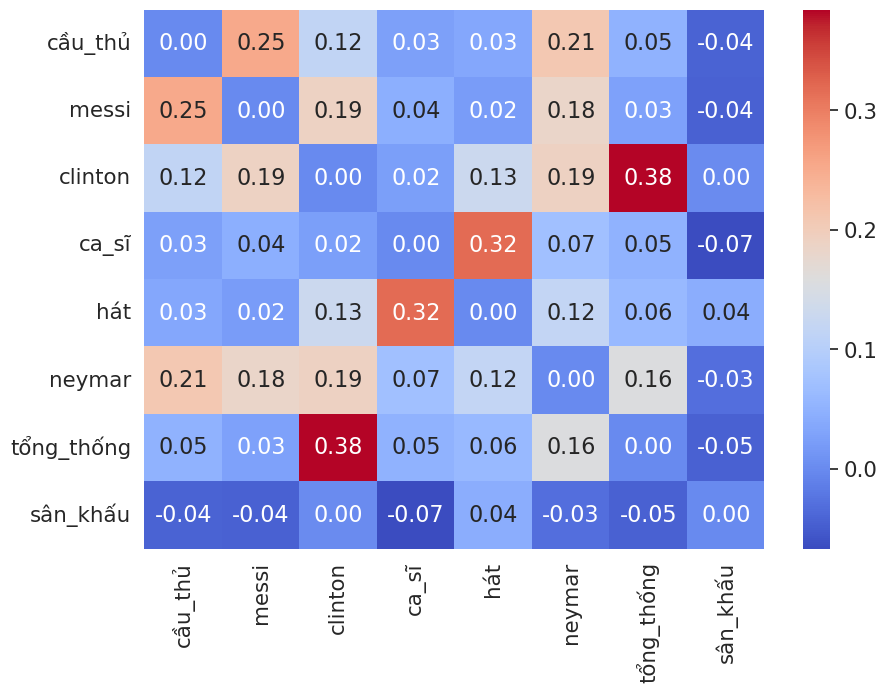

In [131]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

list_words = ["cầu_thủ", "messi", "clinton", "ca_sĩ", "hát", "neymar", "tổng_thống"]
list_word_embs = [
    model.embeddings(torch.tensor(word_to_idx[word], dtype=torch.long).to("cuda"))
    .cpu()
    .detach()
    .numpy()
    for word in list_words
]

similarity_matrix = np.zeros((len(list_words), len(list_words)))
for i in range(len(list_words)):
    for j in range(len(list_words)):
        similarity_matrix[i][j] = torch.cosine_similarity(
            torch.tensor(list_word_embs[i]), torch.tensor(list_word_embs[j]), dim=0
        ).item()

df_dm = pd.DataFrame(similarity_matrix, index=list_words, columns=list_words)

# mask the diagonal
for i in range(len(list_words)):
    df_dm.iloc[i, i] = 0

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(
    df_dm, annot=True, annot_kws={"size": 16}, cmap="coolwarm", fmt=".2f"
)  # font size

plt.show()